<a href="https://colab.research.google.com/github/MaCuur/AI_EGs/blob/main/LSTM_precipitacion_univariado_horizons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM univariado — Predicción de precipitación (horizontes 1,3,5,7 días)

Este notebook contiene todo el flujo para entrenar modelos LSTM univariados sobre la serie `precipitacion_mm` del archivo `9020_CIUDAD DE MEXICO_9020_2020_precipitacion.csv`.

⚠️ **Nota:** Este entorno donde ejecuté la prueba **no tiene TensorFlow instalado**, por lo que no fue posible entrenar aquí. Puedes ejecutar este notebook localmente o en Google Colab (recomiendo Colab) tras instalar TensorFlow.

Instrucciones rápidas para Colab:
1. Subir `9020_CIUDAD_DE_MEXICO_9020_2020_precipitacion.csv` al panel de archivos (o montar Google Drive).
2. Ejecutar la celda siguiente para instalar dependencias:
```bash
!pip install -q tensorflow scikit-learn joblib
```
3. Ejecutar las celdas en orden.


In [ ]:
!pip install -q tensorflow scikit-learn joblib
!pip install tensorflow

In [ ]:
# Imports y parámetros
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

RESULT_DIR = "/content/lstm_results_univariado"  # en Colab usa /content
os.makedirs(RESULT_DIR, exist_ok=True)

CSV_PATH = "9020_CIUDAD DE MEXICO_9020_2020_precipitacion.csv"  # asegura la ruta
SEQUENCE_LENGTH = 30
HORIZONS = [1,3,5,7]
TEST_SIZE = 0.2
VAL_SIZE = 0.1
BATCH_SIZE = 32
EPOCHS = 100
RANDOM_SEED = 42


In [ ]:
# Cargar datos y reconstruir fecha
df = pd.read_csv(CSV_PATH)
if set(['año','mes','dia']).issubset(df.columns):
    df['fecha'] = pd.to_datetime(dict(year=df['año'], month=df['mes'], day=df['dia']), errors='coerce')
else:
    date_cols = [c for c in df.columns if 'fecha' in c.lower() or 'date' in c.lower()]
    if date_cols:
        df['fecha'] = pd.to_datetime(df[date_cols[0]], errors='coerce')
    else:
        df['fecha'] = pd.RangeIndex(start=0, stop=len(df))

df = df.sort_values('fecha').reset_index(drop=True)
print('Columnas del CSV:', df.columns.tolist())
print(df.head())


Columnas del CSV: ['precipitacion_mm', 'mes', 'dia', 'año', 'fecha']
   precipitacion_mm  mes  dia   año      fecha
0                 0    1    1  2020 2020-01-01
1                 0    1    2  2020 2020-01-02
2                 0    1    3  2020 2020-01-03
3                 0    1    4  2020 2020-01-04
4                 0    1    5  2020 2020-01-05


In [ ]:
# Preparar serie univariada
target_col = 'precipitacion_mm'
series = df[[ 'fecha', target_col ]].copy()
series[target_col] = pd.to_numeric(series[target_col], errors='coerce').fillna(0.0)

scaler = StandardScaler()
scaled_vals = scaler.fit_transform(series[[target_col]].values)
joblib.dump(scaler, os.path.join(RESULT_DIR, 'scaler_univariado.pkl'))

def create_sequences_univar(arr, seq_len, horizon):
    X, y = [], []
    n = len(arr)
    for i in range(n - seq_len - horizon + 1):
        X.append(arr[i:i+seq_len].reshape(seq_len, 1))
        y.append(arr[i+seq_len:i+seq_len+horizon])
    return np.array(X), np.array(y)

print('Preparado. Datos escalados y scaler guardado en', os.path.join(RESULT_DIR, 'scaler_univariado.pkl'))


Preparado. Datos escalados y scaler guardado en /content/lstm_results_univariado/scaler_univariado.pkl


In [ ]:
# Entrenamiento (requiere TensorFlow). Si usas Colab, instala con: !pip install -q tensorflow
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError # Import explicit metrics
    tf.random.set_seed(RANDOM_SEED)
except Exception as e:
    raise ImportError('TensorFlow no está instalado. Ejecuta: !pip install -q tensorflow')

results = []
for h in HORIZONS:
    X, y = create_sequences_univar(scaled_vals.flatten(), SEQUENCE_LENGTH, h)
    if h == 1:
        y = y.reshape(-1,)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=False)
    val_frac_of_train = VAL_SIZE / (1.0 - TEST_SIZE)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=val_frac_of_train, shuffle=False)

    model = Sequential([
        LSTM(64, input_shape=(SEQUENCE_LENGTH, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(h)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    model_path = os.path.join(RESULT_DIR, f'lstm_univar_h{h}.h5')
    checkpoint_cb = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min')
    early_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_cb], verbose=2)

    # Provide custom_objects for loading the model
    custom_objects = {
        'mse': MeanSquaredError(),
        'mae': MeanAbsoluteError()
    }
    best_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    y_pred_scaled = best_model.predict(X_test)
    if h == 1:
        y_pred_scaled = y_pred_scaled.reshape(-1,)

    # invertir escala primer paso del horizonte
    def inverse_univar(y_scaled, scaler):
        y_scaled = np.array(y_scaled)
        if y_scaled.ndim == 1:
            arr = np.zeros((len(y_scaled), 1)); arr[:,0] = y_scaled; return scaler.inverse_transform(arr)[:,0]
        else:
            n = y_scaled.shape[0]; out = []
            for i in range(n):
                arr = np.zeros((1,1)); arr[0,0] = y_scaled[i,0]
                out.append(scaler.inverse_transform(arr)[0,0])
            return np.array(out)


    if h == 1:
        y_test_inv = inverse_univar(y_test, scaler)
        y_pred_inv = inverse_univar(y_pred_scaled, scaler)
    else:
        y_test_first = y_test[:,0]
        y_pred_first = y_pred_scaled[:,0]
        y_test_inv = inverse_univar(y_test_first, scaler)
        y_pred_inv = inverse_univar(y_pred_first, scaler)

    # guardar CSV y gráficas
    total_seqs = X.shape[0]
    global_target_indices = [i + SEQUENCE_LENGTH for i in range(total_seqs)]
    test_global_indices = global_target_indices[-len(X_test):]
    dates_test = series['fecha'].iloc[test_global_indices].reset_index(drop=True)

    out_df = pd.DataFrame({'fecha': dates_test, 'y_real': y_test_inv, 'y_pred': y_pred_inv})
    out_df.to_csv(os.path.join(RESULT_DIR, f'predicciones_h{h}.csv'), index=False)

    # Plots
    plt.figure(figsize=(10,4))
    nplot = min(200, len(y_test_inv))
    plt.plot(y_test_inv[:nplot], label='real')
    plt.plot(y_pred_inv[:nplot], label='predicho')
    plt.xlabel('Muestras (test)')
    plt.ylabel('Precipitación (mm)')
    plt.legend()
    plt.title(f'Predicción vs Real - Horizonte {h} días')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULT_DIR, f'pred_vs_real_h{h}.png'))
    plt.close()

    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.xlabel('Época')
    plt.ylabel('MSE')
    plt.legend()
    plt.title(f'Loss entrenamiento - Horizonte {h} días')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULT_DIR, f'train_loss_h{h}.png'))
    plt.close()

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)

    results.append({'h': h, 'mse': float(mse), 'mae': float(mae), 'csv': os.path.join(RESULT_DIR, f'predicciones_h{h}.csv')})

results

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 - 5s - 568ms/step - loss: 1.3451 - mae: 0.6993 - val_loss: 0.5704 - val_mae: 0.6884
Epoch 2/100
8/8 - 0s - 39ms/step - loss: 1.1891 - mae: 0.6287 - val_loss: 0.9945 - val_mae: 0.8873
Epoch 3/100
8/8 - 0s - 37ms/step - loss: 1.1785 - mae: 0.6117 - val_loss: 0.8686 - val_mae: 0.8556
Epoch 4/100
8/8 - 0s - 39ms/step - loss: 1.1429 - mae: 0.6268 - val_loss: 0.7920 - val_mae: 0.8322
Epoch 5/100
8/8 - 0s - 60ms/step - loss: 1.1491 - mae: 0.6291 - val_loss: 0.8570 - val_mae: 0.8680
Epoch 6/100
8/8 - 1s - 77ms/step - loss: 1.1273 - mae: 0.6075 - val_loss: 0.9722 - val_mae: 0.9257
Epoch 7/100
8/8 - 1s - 80ms/step - loss: 1.1105 - mae: 0.6056 - val_loss: 1.0454 - val_mae: 0.9645
Epoch 8/100
8/8 - 0s - 62ms/step - loss: 1.0892 - mae: 0.6000 - val_loss: 1.0545 - val_mae: 0.9723
Epoch 9/100
8/8 - 0s - 53ms/step - loss: 1.0943 - mae: 0.5985 - val_loss: 1.0496 - val_mae: 0.9710
Epoch 10/100
8/8 - 0s - 37ms/step - loss: 1.0896 - mae: 0.5855 - val_loss: 1.1124 - val_mae: 0.9993
Epoch 11/100
8/8 - 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 - 5s - 568ms/step - loss: 1.4087 - mae: 0.7204 - val_loss: 0.4312 - val_mae: 0.5708
Epoch 2/100
8/8 - 0s - 37ms/step - loss: 1.2701 - mae: 0.6713 - val_loss: 0.7678 - val_mae: 0.7833
Epoch 3/100
8/8 - 0s - 38ms/step - loss: 1.1313 - mae: 0.6140 - val_loss: 1.1547 - val_mae: 1.0040
Epoch 4/100
8/8 - 0s - 40ms/step - loss: 1.1273 - mae: 0.6114 - val_loss: 1.3499 - val_mae: 1.0929
Epoch 5/100
8/8 - 0s - 37ms/step - loss: 1.1377 - mae: 0.6549 - val_loss: 1.3388 - val_mae: 1.0930
Epoch 6/100
8/8 - 0s - 37ms/step - loss: 1.0854 - mae: 0.6405 - val_loss: 1.4979 - val_mae: 1.1527
Epoch 7/100
8/8 - 0s - 41ms/step - loss: 1.0767 - mae: 0.5954 - val_loss: 1.4788 - val_mae: 1.1460
Epoch 8/100
8/8 - 0s - 37ms/step - loss: 1.0803 - mae: 0.6032 - val_loss: 1.5065 - val_mae: 1.1544
Epoch 9/100
8/8 - 0s - 39ms/step - loss: 1.0554 - mae: 0.5958 - val_loss: 1.7469 - val_mae: 1.2375
Epoch 10/100
8/8 - 0s - 40ms/step - loss: 1.0545 - mae: 0.5932 - val_loss: 1.8726 - val_mae: 1.2710
Epoch 11/100
8/8 - 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 - 4s - 553ms/step - loss: 1.4504 - mae: 0.7361 - val_loss: 0.4574 - val_mae: 0.5455
Epoch 2/100
8/8 - 0s - 37ms/step - loss: 1.4008 - mae: 0.6870 - val_loss: 0.4615 - val_mae: 0.5532
Epoch 3/100
8/8 - 0s - 40ms/step - loss: 1.3539 - mae: 0.6237 - val_loss: 0.5570 - val_mae: 0.6183
Epoch 4/100
8/8 - 0s - 37ms/step - loss: 1.3077 - mae: 0.6218 - val_loss: 0.7129 - val_mae: 0.7256
Epoch 5/100
8/8 - 0s - 37ms/step - loss: 1.2466 - mae: 0.6302 - val_loss: 0.8264 - val_mae: 0.8341
Epoch 6/100
8/8 - 0s - 40ms/step - loss: 1.1577 - mae: 0.6232 - val_loss: 1.0463 - val_mae: 0.9553
Epoch 7/100
8/8 - 0s - 37ms/step - loss: 1.1363 - mae: 0.6121 - val_loss: 1.2362 - val_mae: 1.0435
Epoch 8/100
8/8 - 0s - 37ms/step - loss: 1.1205 - mae: 0.6016 - val_loss: 1.2679 - val_mae: 1.0577
Epoch 9/100
8/8 - 0s - 39ms/step - loss: 1.1038 - mae: 0.5937 - val_loss: 1.4056 - val_mae: 1.1092
Epoch 10/100
8/8 - 0s - 36ms/step - loss: 1.0872 - mae: 0.6018 - val_loss: 1.5364 - val_mae: 1.1534
Epoch 11/100
8/8 - 0

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 - 5s - 687ms/step - loss: 1.4560 - mae: 0.7466 - val_loss: 0.4335 - val_mae: 0.5515
Epoch 2/100
8/8 - 0s - 36ms/step - loss: 1.4062 - mae: 0.7322 - val_loss: 0.4833 - val_mae: 0.5926
Epoch 3/100
8/8 - 0s - 37ms/step - loss: 1.3358 - mae: 0.7014 - val_loss: 0.6879 - val_mae: 0.7171
Epoch 4/100
8/8 - 0s - 37ms/step - loss: 1.2769 - mae: 0.6587 - val_loss: 0.9114 - val_mae: 0.8355
Epoch 5/100
8/8 - 0s - 41ms/step - loss: 1.2433 - mae: 0.6406 - val_loss: 0.9476 - val_mae: 0.8613
Epoch 6/100
8/8 - 0s - 37ms/step - loss: 1.2142 - mae: 0.6337 - val_loss: 0.9504 - val_mae: 0.8718
Epoch 7/100
8/8 - 0s - 37ms/step - loss: 1.2039 - mae: 0.6006 - val_loss: 0.9816 - val_mae: 0.8944
Epoch 8/100
8/8 - 0s - 40ms/step - loss: 1.1728 - mae: 0.6130 - val_loss: 1.0411 - val_mae: 0.9286
Epoch 9/100
8/8 - 0s - 36ms/step - loss: 1.1802 - mae: 0.6023 - val_loss: 1.0666 - val_mae: 0.9458
Epoch 10/100
8/8 - 0s - 38ms/step - loss: 1.1684 - mae: 0.6007 - val_loss: 1.1118 - val_mae: 0.9699
Epoch 11/100
8/8 - 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


[{'h': 1,
  'mse': 0.07602874659692548,
  'mae': 0.27239241155600163,
  'csv': '/content/lstm_results_univariado/predicciones_h1.csv'},
 {'h': 3,
  'mse': 0.1912387558589349,
  'mae': 0.43707940116024957,
  'csv': '/content/lstm_results_univariado/predicciones_h3.csv'},
 {'h': 5,
  'mse': 0.20159480598262067,
  'mae': 0.44854914366982224,
  'csv': '/content/lstm_results_univariado/predicciones_h5.csv'},
 {'h': 7,
  'mse': 0.27636399326322564,
  'mae': 0.5256978504143239,
  'csv': '/content/lstm_results_univariado/predicciones_h7.csv'}]

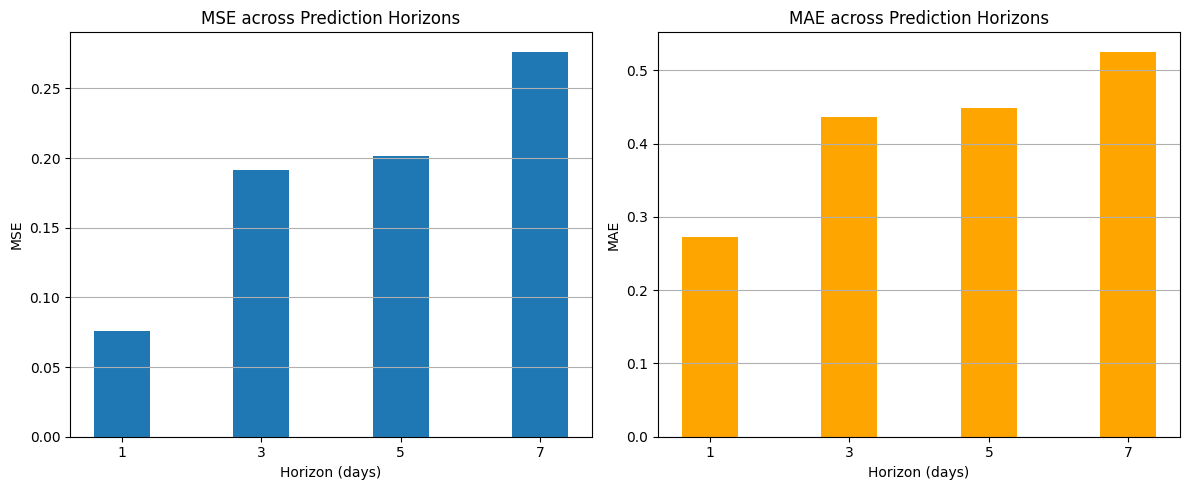

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

results_df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot MSE
axes[0].bar(results_df['h'], results_df['mse'])
axes[0].set_title('MSE across Prediction Horizons')
axes[0].set_xlabel('Horizon (days)')
axes[0].set_ylabel('MSE')
axes[0].set_xticks(results_df['h'])
axes[0].grid(axis='y')

# Plot MAE
axes[1].bar(results_df['h'], results_df['mae'], color='orange')
axes[1].set_title('MAE across Prediction Horizons')
axes[1].set_xlabel('Horizon (days)')
axes[1].set_ylabel('MAE')
axes[1].set_xticks(results_df['h'])
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

In [ ]:
display(results)

[{'h': 1,
  'mse': 0.07602874659692548,
  'mae': 0.27239241155600163,
  'csv': '/content/lstm_results_univariado/predicciones_h1.csv'},
 {'h': 3,
  'mse': 0.1912387558589349,
  'mae': 0.43707940116024957,
  'csv': '/content/lstm_results_univariado/predicciones_h3.csv'},
 {'h': 5,
  'mse': 0.20159480598262067,
  'mae': 0.44854914366982224,
  'csv': '/content/lstm_results_univariado/predicciones_h5.csv'},
 {'h': 7,
  'mse': 0.27636399326322564,
  'mae': 0.5256978504143239,
  'csv': '/content/lstm_results_univariado/predicciones_h7.csv'}]

Displaying Prediction vs Actual plots:

Horizon 1 days:


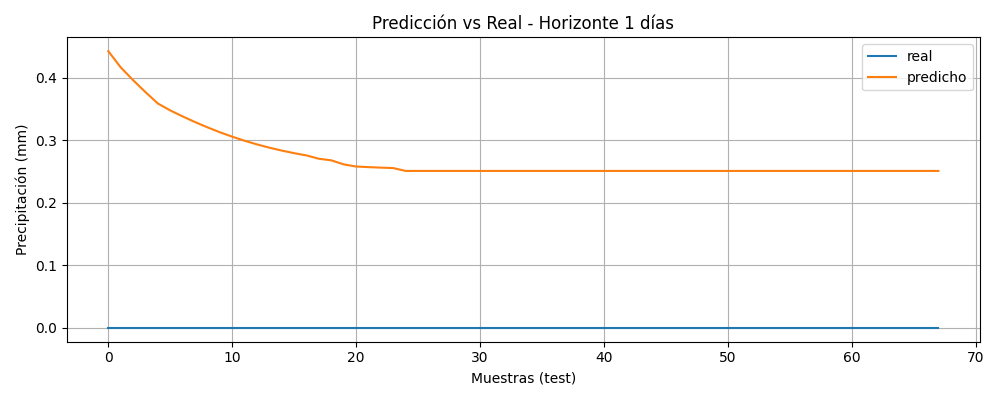


Horizon 3 days:


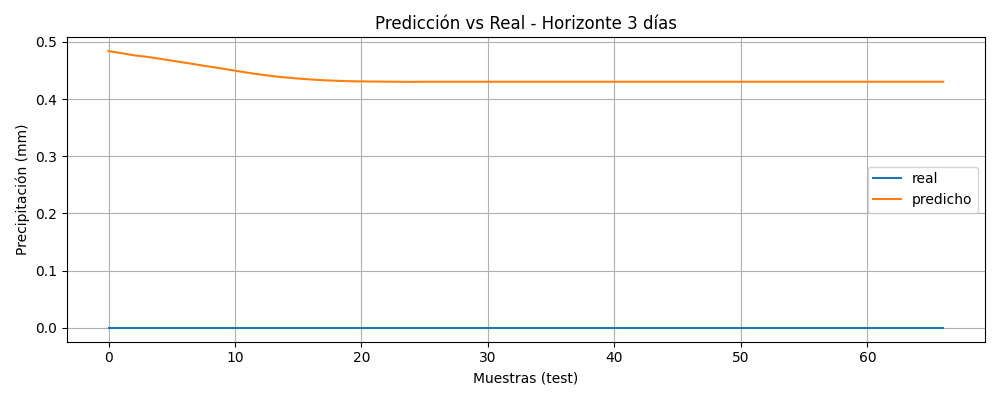


Horizon 5 days:


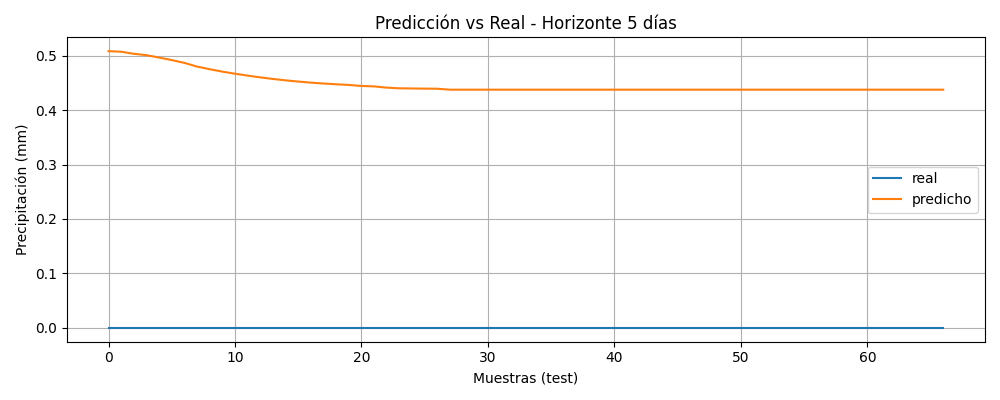


Horizon 7 days:


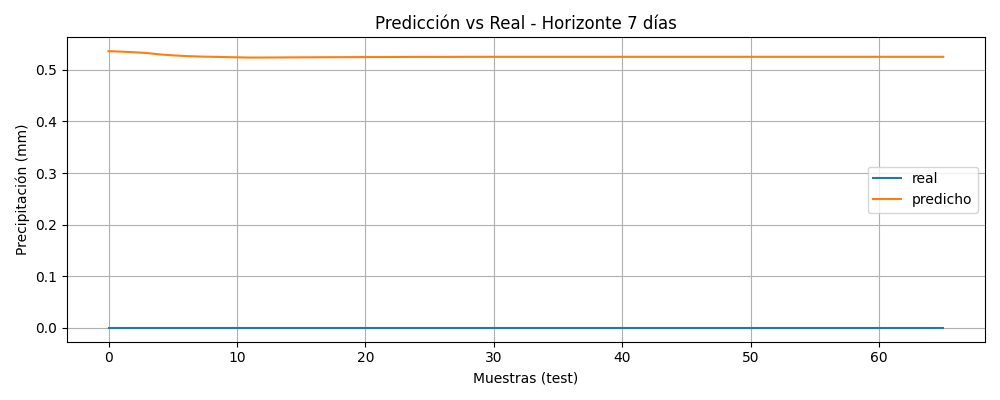

In [ ]:
from IPython.display import Image, display
import os

result_dir = "/content/lstm_results_univariado"
horizons = [1, 3, 5, 7] # Assuming these are the horizons used

print("Displaying Prediction vs Actual plots:")
for h in horizons:
    plot_path = os.path.join(result_dir, f'pred_vs_real_h{h}.png')
    if os.path.exists(plot_path):
        print(f"\nHorizon {h} days:")
        display(Image(filename=plot_path))
    else:
        print(f"\nPlot for Horizon {h} not found at {plot_path}")

## Qué entregará este notebook
- Modelos guardados: `lstm_univar_h{h}.h5` por cada horizonte
- Scaler: `scaler_univariado.pkl`
- CSVs con predicciones: `predicciones_h{h}.csv`
- Gráficas `pred_vs_real_h{h}.png` y `train_loss_h{h}.png`

### Nota final
Si quieres, puedo ahora:
1. Guardar este notebook en `/mnt/data/` para que lo descargues. (ya lo hice abajo)
2. Preparar un `README` corto con instrucciones paso a paso para ejecutarlo en Colab.


# Task
Explain how to tune the hyperparameters of the LSTM model.

## Identify hyperparameters to tune

### Subtask:
Determine which hyperparameters of the LSTM model and the training process (e.g., number of LSTM units, dropout rates, learning rate, batch size, number of epochs) you want to tune.


**Reasoning**:
Review the existing code to identify the hyperparameters that can be tuned for the LSTM model and training process based on the instructions.



In [ ]:
# Review of hyperparameters in the existing code:

# Model architecture:
# - LSTM(64, input_shape=(SEQUENCE_LENGTH, 1), return_sequences=True): Number of units (64)
# - Dropout(0.2): Dropout rate (0.2)
# - LSTM(32, return_sequences=False): Number of units (32)
# - Dropout(0.2): Dropout rate (0.2)
# - Dense(16, activation='relu'): Number of units (16)
# - Dense(h): Output layer, fixed by horizon h

# Model compilation:
# - optimizer='adam': Adam optimizer is used. Learning rate is a potential hyperparameter here.
# - loss='mse': Loss function is fixed.
# - metrics=['mae']: Metrics are fixed.

# Training process:
# - BATCH_SIZE: Batch size (32)
# - EPOCHS: Maximum number of epochs (100), but early stopping is used.
# - EarlyStopping(monitor='val_loss', patience=10): Patience parameter (10)
# - ModelCheckpoint: Saves the best model based on validation loss.

# Data preparation:
# - SEQUENCE_LENGTH: Lookback window (30). This could potentially be tuned.
# - HORIZONS: Prediction horizons (1, 3, 5, 7). These are fixed by the problem definition.
# - TEST_SIZE, VAL_SIZE: Data split ratios (0.2, 0.1). These could potentially be tuned, but often kept fixed.

# Based on the instructions and code review, the hyperparameters to focus on for tuning are:
# - Number of units in LSTM layers (e.g., 64, 32)
# - Dropout rates (e.g., 0.2)
# - Learning rate of the optimizer (if using a custom optimizer with a defined learning rate, or tuning the default Adam learning rate via optimizer arguments)
# - BATCH_SIZE
# - Early Stopping patience
# - SEQUENCE_LENGTH

tuned_hyperparameters = [
    "LSTM_units_layer1",
    "LSTM_units_layer2",
    "Dropout_rate_layer1",
    "Dropout_rate_layer2",
    "Dense_units_layer3", # Although not explicitly mentioned in instructions, this is part of the model architecture
    "Learning_rate",
    "BATCH_SIZE",
    "EarlyStopping_patience",
    "SEQUENCE_LENGTH"
]

print("Hyperparameters to be considered for tuning:")
for hp in tuned_hyperparameters:
    print(f"- {hp}")

Hyperparameters to be considered for tuning:
- LSTM_units_layer1
- LSTM_units_layer2
- Dropout_rate_layer1
- Dropout_rate_layer2
- Dense_units_layer3
- Learning_rate
- BATCH_SIZE
- EarlyStopping_patience
- SEQUENCE_LENGTH
